# Predicting Stock Prices in Python: Vid from Sean  

https://www.youtube.com/watch?v=PuZY9q-aKLw

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt
import investpy as ipy

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler

# from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

from keras.models import Sequential
from keras.preprocessing.sequence import TimeseriesGenerator


# from keras.layers import Dense
# from keras.layers import LSTM

In [2]:
company = 'FB'

start = '01/01/2012'
end = '01/01/2020'

# data = web.DataReader(company, 'yahoo', start, end)
data = ipy.get_stock_historical_data(stock=company,
                                          country='United States',
                                          from_date=start,
                                          to_date=end)

In [10]:
data.head()

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2012-05-18,42.05,45.00,38.00,38.23,580587712,USD
2012-05-21,36.53,36.66,33.00,34.03,168309824,USD
2012-05-22,32.61,33.59,30.94,31.00,102053824,USD
2012-05-23,31.37,32.50,31.36,32.00,73721136,USD
2012-05-24,32.95,33.21,31.77,33.03,50275880,USD


In [3]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

prediction_days = 60

X_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    
    X_train.append(scaled_data[x - prediction_days: x, 0])
    y_train.append(scaled_data[x, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [4]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(units=1)) # Prediction of the next closing value

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=20, batch_size=32)

# modelscores = model.evaluate(X, Y, verbose=0)
# print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Epoch 1/20
59/59 [==============================] - 5s 37ms/step - loss: 0.0310
Epoch 2/20
59/59 [==============================] - 2s 36ms/step - loss: 0.0040
Epoch 3/20
59/59 [==============================] - 2s 37ms/step - loss: 0.0034
Epoch 4/20
59/59 [==============================] - 2s 36ms/step - loss: 0.0035
Epoch 5/20
59/59 [==============================] - 2s 36ms/step - loss: 0.0034
Epoch 6/20
59/59 [==============================] - 2s 36ms/step - loss: 0.0028
Epoch 7/20
59/59 [==============================] - 2s 37ms/step - loss: 0.0037
Epoch 8/20
59/59 [==============================] - 2s 36ms/step - loss: 0.0031
Epoch 9/20
59/59 [==============================] - 2s 36ms/step - loss: 0.0032
Epoch 10/20
59/59 [==============================] - 2s 36ms/step - loss: 0.0027
Epoch 11/20
59/59 [==============================] - 2s 36ms/step - loss: 0.0030
Epoch 12/20
59/59 [==============================] - 2s 36ms/step - loss: 0.0027
Epoch 13/20
59/59 [==================

In [5]:
model.save('pred_stck_prices.h5')

# # load model
# model = load_model('pred_stck_prices.h5')
# # summarize model.
# model.summary()

In [6]:
'''Test model accuracy on existing data'''

# Load test data
test_start = '01/01/2020'

today = dt.date.today()
today_proper = today.strftime("%d/%m/%Y")
test_end = today_proper

test_data = ipy.get_stock_historical_data(stock=company,
                              country='United States',
                              from_date=test_start,
                              to_date=test_end)

# If you utilize test/train/split then X_test will function as t
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']))

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)

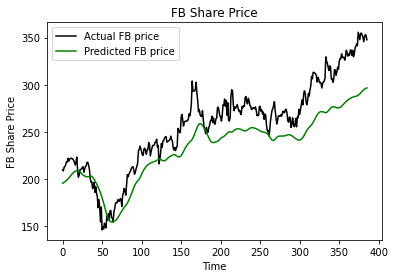

In [7]:
'''Make predictions on test data'''

X_test = []

for x in range(prediction_days, len(model_inputs)):
    
    X_test.append(model_inputs[x - prediction_days:x, 0])
    
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

# Plot the test predictions
plt.plot(actual_prices, color='black', label=f'Actual {company} price')
plt.plot(predicted_prices, color='green', label=f'Predicted {company} price')
plt.title(f'{company} Share Price')
plt.xlabel('Time')
plt.ylabel(f'{company} Share Price')
plt.legend()
plt.show()

In [9]:
# Predict Next Day
real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs + 1), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f'Prediction: {prediction}')

Prediction: [[296.84906]]


# Rolling Forecast Origin

In [3]:
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([1, 2, 3, 4, 5, 6])
tscv = TimeSeriesSplit(max_train_size=3)
print(tscv)

for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TimeSeriesSplit(max_train_size=3, n_splits=5)
TRAIN: [0] TEST: [1]
TRAIN: [0 1] TEST: [2]
TRAIN: [0 1 2] TEST: [3]
TRAIN: [1 2 3] TEST: [4]
TRAIN: [2 3 4] TEST: [5]


In [4]:
# define dataset
series = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# define generator
n_input = 2
generator = TimeseriesGenerator(series, series, length=n_input, batch_size=1)

# number of samples
print('Samples: %d' % len(generator))

for i in range(len(generator)):
	x, y = generator[i]
	print('%s => %s' % (x, y))

Samples: 8
[[1 2]] => [3]
[[2 3]] => [4]
[[3 4]] => [5]
[[4 5]] => [6]
[[5 6]] => [7]
[[6 7]] => [8]
[[7 8]] => [9]
[[8 9]] => [10]


In [5]:
# MLP

series = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
print(series.shape)
# define generator
n_input = 2
generator = TimeseriesGenerator(series, series, length=n_input, batch_size=8)

(10,)


In [6]:
# define model
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=n_input))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [7]:
# fit model
model.fit_generator(generator, steps_per_epoch=1, epochs=200, verbose=0)

/home/bobbyhuck/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


In [8]:
# make a one step prediction out of sample
x_input = np.array([9, 10]).reshape((1, n_input))
yhat = model.predict(x_input, verbose=0)
print('Predicted value:', yhat[0][0])

Predicted value: 11.561013


In [23]:
#LSTM

# define dataset
series = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
print(series.shape)
# reshape to [10, 1]
n_features = 1
series = series.reshape((len(series), n_features))
print(series.shape)

(10,)
(10, 1)


In [24]:
# define generator
n_input = 2
generator = TimeseriesGenerator(series, series, length=n_input, batch_size=8)

In [25]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [26]:
# fit model
model.fit_generator(generator, steps_per_epoch=1, epochs=500, verbose=0)

In [27]:
# make a one step prediction out of sample
x_input = np.array([9, 10]).reshape((1, n_input, n_features))
yhat = model.predict(x_input, verbose=0)
print('Predicted value:', yhat[0][0])

Predicted value: 10.926098


# BITCOIN DIRTY

In [ ]:
def rolling_forecast_origin(train, min_train_size, horizon):
    '''Rolling forecast origin generator'''
    
    for i in range(len(train) - min_train_size)

In [2]:
# Load Data
company = 'bitcoin'

start = '01/01/2010'
end = '01/01/2020'

# data = web.DataReader(company, 'yahoo', start, end)
data = ipy.get_crypto_historical_data(crypto=company,
                                      from_date=start,
                                      to_date=end)

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

prediction_days = 12 # Shorter prediction days makes it more sensitive to fluctuations

X_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    
    X_train.append(scaled_data[x - prediction_days: x, 0])
    y_train.append(scaled_data[x, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [57]:
# Load Data
company = 'bitcoin'

start = '01/01/2010'
end = '01/01/2020'

# data = web.DataReader(company, 'yahoo', start, end)
data = ipy.get_crypto_historical_data(crypto=company,
                                      from_date=start,
                                      to_date=end)

# define dataset
series = np.array(data['Close'])
series

array([1.0000e-01, 1.0000e-01, 1.0000e-01, ..., 7.2618e+03, 7.1964e+03,
       7.1998e+03])

In [60]:
# TIMESERIES GENERATOR

# reshape to [10, 1]
n_features = 1
series = series.reshape((len(series), n_features))

# define generator
n_input = 60
generator = TimeseriesGenerator(series, series, length=n_input, batch_size=60)

# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# fit model
model.fit_generator(generator, steps_per_epoch=1, epochs=500, verbose=0)

# make a one step prediction out of sample
arr = np.array(series[-n_input:])
x_input = arr.reshape((1, n_input, n_features))
yhat = model.predict(x_input, verbose=0)

print('Predicted value:', yhat[0][0])

Predicted value: -1957.7046


In [39]:
# Predicted value: 6948.1514

company = 'bitcoin'

start = '02/01/2020'
end = '03/01/2020'

prediction_check = data = ipy.get_crypto_historical_data(crypto=company,
                                                         from_date=start,
                                                         to_date=end)

prediction_check['Close']

Date
2020-01-02    6967.0
2020-01-03    7343.1
Name: Close, dtype: float64

In [26]:
# Train Model
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularization
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(units=1)) # Prediction of the next closing value

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
108/108 [==============================] - 4s 11ms/step - loss: 0.0040
Epoch 2/20
108/108 [==============================] - 1s 10ms/step - loss: 0.0012
Epoch 3/20
108/108 [==============================] - 1s 10ms/step - loss: 0.0012
Epoch 4/20
108/108 [==============================] - 1s 10ms/step - loss: 0.0011
Epoch 5/20
108/108 [==============================] - 1s 10ms/step - loss: 9.4194e-04
Epoch 6/20
108/108 [==============================] - 1s 10ms/step - loss: 0.0011
Epoch 7/20
108/108 [==============================] - 1s 11ms/step - loss: 9.5776e-04
Epoch 8/20
108/108 [==============================] - 1s 11ms/step - loss: 0.0010
Epoch 9/20
108/108 [==============================] - 1s 10ms/step - loss: 8.2546e-04
Epoch 10/20
108/108 [==============================] - 1s 10ms/step - loss: 7.9724e-04
Epoch 11/20
108/108 [==============================] - 1s 10ms/step - loss: 7.9581e-04
Epoch 12/20
108/108 [==============================] - 1s 10ms/step - loss: 

In [27]:
model.save('btc_pred_stck_prices_12ts.h5')

# # load model
# model = load_model('pred_stck_prices.h5')
# # summarize model.
# model.summary()

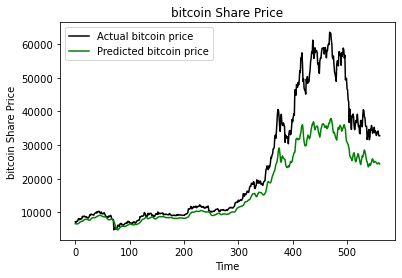

In [28]:
'''Test model accuracy on existing data'''

# Load test data
test_start = '01/01/2020'

today = dt.date.today()
today_proper = today.strftime("%d/%m/%Y")
test_end = today_proper

test_data = ipy.get_crypto_historical_data(crypto=company,
                                      from_date=test_start,
                                      to_date=test_end)

# If you utilize test/train/split then X_test will function as t
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']))

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)

'''Make predictions on test data'''

X_test = []

for x in range(prediction_days, len(model_inputs)):
    
    X_test.append(model_inputs[x - prediction_days:x, 0])
    
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

# Plot the test predictions
plt.plot(actual_prices, color='black', label=f'Actual {company} price')
plt.plot(predicted_prices, color='green', label=f'Predicted {company} price')
plt.title(f'{company} Share Price')
plt.xlabel('Time')
plt.ylabel(f'{company} Share Price')
plt.legend()
plt.show()

In [29]:
# Predict Next Day
real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs + 1), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f'Prediction: {prediction}')

Prediction: [[24102.82]]


# TS @ 60
WARNING:tensorflow:Model was constructed with shape (None, 60, 1) for input KerasTensor(type_spec=TensorSpec(shape=(None, 60, 1), dtype=tf.float32, name='lstm_3_input'), name='lstm_3_input', description="created by layer 'lstm_3_input'"), but it was called on an input with incompatible shape (None, 59, 1).  
Prediction: [[27324.047]]

# TS @ 120
WARNING:tensorflow:Model was constructed with shape (None, 180, 1) for input KerasTensor(type_spec=TensorSpec(shape=(None, 180, 1), dtype=tf.float32, name='lstm_6_input'), name='lstm_6_input', description="created by layer 'lstm_6_input'"), but it was called on an input with incompatible shape (None, 179, 1).  
Prediction: [[26701.621]]

# TS @ 30
WARNING:tensorflow:Model was constructed with shape (None, 30, 1) for input KerasTensor(type_spec=TensorSpec(shape=(None, 30, 1), dtype=tf.float32, name='lstm_9_input'), name='lstm_9_input', description="created by layer 'lstm_9_input'"), but it was called on an input with incompatible shape (None, 29, 1).      
Prediction: [[28587.81]]  

# TS @ 12  
WARNING:tensorflow:Model was constructed with shape (None, 12, 1) for input KerasTensor(type_spec=TensorSpec(shape=(None, 12, 1), dtype=tf.float32, name='lstm_12_input'), name='lstm_12_input', description="created by layer 'lstm_12_input'"), but it was called on an input with incompatible shape (None, 11, 1).   
Prediction: [[24102.82]]
